# End-to-end example: automated spam filtering

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import pickle as cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve

## Step 1: Load data, look around

Skipping the *real* first step (fleshing out specs, finding out what is it we want to be doing -- often highly non-trivial in practice!), let's download the dataset we'll be using in this demo. Go to https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection and download the zip file. 

This file contains **a collection of more than 5 thousand SMS phone messages** (see the `readme` file for more info):

In [5]:
messages = [line.rstrip() for line in open('./spam_ham_data/SMSSpamCollection')]
print(len(messages))

5574


A collection of texts is also sometimes called "corpus". Let's print the first ten messages in this SMS corpus:

In [6]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 

We see that this is a [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) ("tab separated values") file, where the first column is a label saying whether the given message is a normal message ("ham") or "spam". The second column is the message itself.

- This corpus will be our labeled training set. 


- Using these ham/spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. 


- Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.

[![](http://radimrehurek.com/data_science_python/plot_ML_flow_chart_11.png)](http://www.astroml.org/sklearn_tutorial/general_concepts.html#supervised-learning-model-fit-x-y)

Instead of parsing TSV (or CSV, or Excel...) files by hand, we can use Python's `pandas` library to do the work for us:

In [8]:
messages = pandas.read_csv('./spam_ham_data/smsspamcollection', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print(messages.head(20))

   label                                            message
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...
5   spam  FreeMsg Hey there darling it's been 3 week's n...
6    ham  Even my brother is not like to speak with me. ...
7    ham  As per your request 'Melle Melle (Oru Minnamin...
8   spam  WINNER!! As a valued network customer you have...
9   spam  Had your mobile 11 months or more? U R entitle...
10   ham  I'm gonna be home soon and i don't want to tal...
11  spam  SIX chances to win CASH! From 100 to 20,000 po...
12  spam  URGENT! You have won a 1 week FREE membership ...
13   ham  I've been searching for the right words to tha...
14   ham                I HAVE A DATE ON SUNDAY WITH WILL!!
15  spam  XXXMobileMovieClub: To use you

With `pandas`, we can also view aggregate statistics easily:

In [9]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

How long are the messages?

In [11]:
messages['length'] = messages['message'].map(lambda text: len(text))
print(messages.head())

  label                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


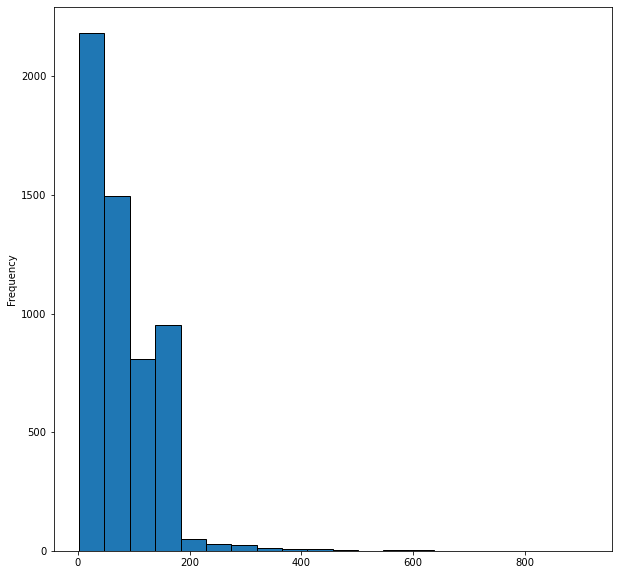

In [12]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
messages.length.plot(bins=20, kind='hist', edgecolor='black', ax=ax)

In [13]:
messages.length.describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

What is that super long message?

In [14]:
print(list(messages.message[messages.length > 900]))

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


Is there any difference in message length between spam and ham?

/Users/etibaraliyev/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:412: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa13498bfa0>,
      dtype=object)

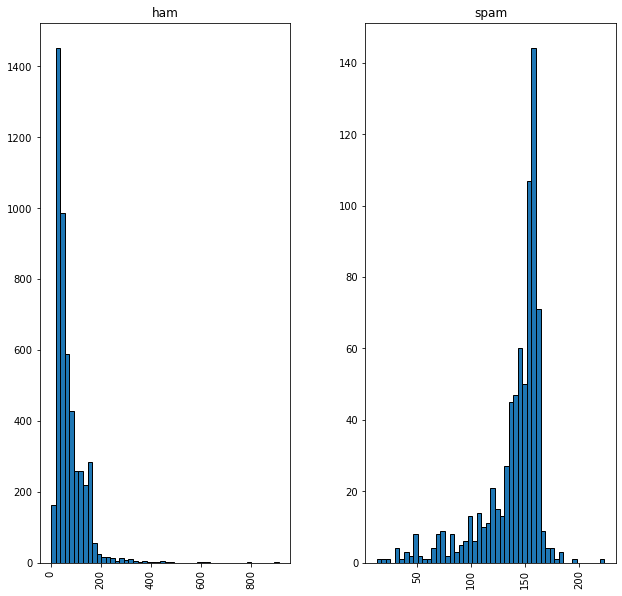

In [15]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
messages.hist(column='length', by='label', bins=50, edgecolor='black', ax=ax)

Good fun, but how do we make computer understand the plain text messages themselves? Or can it under such malformed gibberish at all?

## Step 2: Data preprocessing

In this section we'll massage the raw messages (sequence of characters) into vectors (sequences of numbers).

The mapping is not 1-to-1; we'll use the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.

As a first step, let's write a function that will split a message into its individual words:

In [18]:
from nltk.tokenize import sent_tokenize

In [19]:
def split_into_tokens(message):
    wt = sent_tokenize(message)
    return TextBlob(message).words

Here are some of the original texts again:
    

In [20]:
messages.message.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

...and here are the same messages, tokenized:

In [21]:
messages.message.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

***NLP questions:***

1. Do capital letters carry information?


2. Does distinguishing inflected form ("goes" vs. "go") carry information?


3. Do interjections, determiners carry information?

In other words, we want to better ***"normalize"*** the text.

With textblob, we'd detect [part-of-speech (POS)](http://www.ling.upenn.edu/courses/Fall_2007/ling001/penn_treebank_pos.html) tags with:

In [22]:
TextBlob("Hello world, how is it going?").tags  # list of (word, POS) pairs

[('Hello', 'NNP'),
 ('world', 'NN'),
 ('how', 'WRB'),
 ('is', 'VBZ'),
 ('it', 'PRP'),
 ('going', 'VBG')]

and normalize words into their base form ([lemmas](http://en.wikipedia.org/wiki/Lemmatisation)) with:

In [23]:
from nltk.stem import WordNetLemmatizer

In [24]:
def split_into_lemmas(message):
    message = message.lower()
    lemma = WordNetLemmatizer()
    message = lemma.lemmatize(message)
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

messages.message.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

Better. You can probably think of many more ways to improve the preprocessing: decoding HTML entities (those `&amp;` and `&lt;` we saw above); filtering out stop words (pronouns etc); adding more features, such as an word-in-all-caps indicator and so on.

## Step 3: Data to vectors

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps, in the ***bag-of-words model***:

1. **counting** how many times does a word occur in each message (term frequency)


2. **weighting** the counts, so that frequent tokens get lower weight (inverse document frequency)


3. **normalizing** the vectors to unit length, to abstract from the original text length (L2 norm)

Each vector has as many dimensions as there are unique words in the SMS corpus:

In [29]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print len(bow_transformer.vocabulary_)

8859


Here we used `scikit-learn` (`sklearn`), a powerful Python library for teaching machine learning. It contains a multitude of various methods and options.

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [30]:
message4 = messages['message'][3]
print message4

U dun say so early hor... U c already then say...


In [31]:
bow4 = bow_transformer.transform([message4])
print bow4
print bow4.shape

  (0, 1158)	1
  (0, 1897)	1
  (0, 2893)	1
  (0, 2923)	1
  (0, 4017)	1
  (0, 6726)	2
  (0, 7101)	1
  (0, 7687)	1
  (0, 8002)	2
(1, 8859)


So, nine unique words in message nr. 4, two of them appear twice, the rest only once. Sanity check: what are these words the appear twice?

In [32]:
print bow_transformer.get_feature_names()[6736]
print bow_transformer.get_feature_names()[8013]

scared
ugadi


The bag-of-words counts for the entire SMS corpus are a large, sparse matrix:

In [33]:
messages_bow = bow_transformer.transform(messages['message'])
print 'sparse matrix shape:', messages_bow.shape
print 'number of non-zeros:', messages_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))

sparse matrix shape: (5574, 8859)
number of non-zeros: 80338
sparsity: 0.16%


And finally, after the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf) 
-  term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.



- **TF: Term Frequency**, which measures how frequently a term occurs in a document. 

    - Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. 
    - Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

    <center>***TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)***</center>




- **IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. 
    - However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. 
    - Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

    <center> ***IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*** </center>


- Example:

    - Consider a document containing 100 words wherein the word cat appears 3 times. 
        - The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. 
    - Now, assume we have 10 million documents and the word cat appears in one thousand of these. 
        - Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. 
    - Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.



TF-IDF can be used by scikit-learn's `TfidfTransformer`:

In [34]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print tfidf4

  (0, 8002)	0.305003902449
  (0, 7687)	0.225308304351
  (0, 7101)	0.191397477878
  (0, 6726)	0.523390707413
  (0, 4017)	0.456371992578
  (0, 2923)	0.329688073969
  (0, 2893)	0.303704626273
  (0, 1897)	0.246652416565
  (0, 1158)	0.274944401638


What is the IDF (inverse document frequency) of the word `"u"`? Of word `"university"`?

In [35]:
print tfidf_transformer.idf_[bow_transformer.vocabulary_['u']]
print tfidf_transformer.idf_[bow_transformer.vocabulary_['university']]

2.84954060396
8.23975323521


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [36]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print messages_tfidf.shape

(5574, 8859)


There are a multitude of ways in which data can be proprocessed and vectorized. 

- These two steps, also called **"feature engineering"**, are typically the most time consuming and "unsexy" parts of building a predictive pipeline, but they are very important and require some experience. 


- The trick is to **evaluate constantly**: analyze model for the errors it makes, improve data cleaning & preprocessing, brainstorm for new features, evaluate...

## Step 4: Training a model, detecting spam

With messages represented as vectors, we can finally train our spam/ham classifier. This part is pretty straightforward, and there are many libraries that realize the training algorithms.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [37]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

CPU times: user 11.7 ms, sys: 1.45 ms, total: 13.2 ms
Wall time: 13.7 ms


Let's try classifying our single random message:

In [38]:
print 'predicted:', spam_detector.predict(tfidf4)[0]
print 'expected:', messages.label[3]

predicted: ham
expected: ham


Hooray! You can try it with your own texts, too.

A natural question is to ask, how many messages do we classify correctly overall?

In [39]:
all_predictions = spam_detector.predict(messages_tfidf)
print all_predictions

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham']


In [40]:
print 'accuracy', accuracy_score(messages['label'], all_predictions)
print 'confusion matrix\n', confusion_matrix(messages['label'], all_predictions)
print '(row=expected, col=predicted)'

accuracy 0.969501255831
confusion matrix
[[4827    0]
 [ 170  577]]
(row=expected, col=predicted)


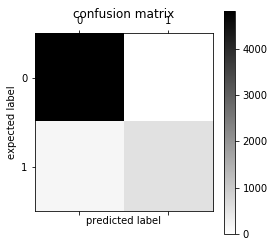

In [44]:
plt.matshow(confusion_matrix(messages['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

From this confusion matrix, we can compute precision and recall, or their combination (harmonic mean) F1:

In [45]:
print classification_report(messages['label'], all_predictions)

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      4827
       spam       1.00      0.77      0.87       747

avg / total       0.97      0.97      0.97      5574



There are quite a few possible metrics for evaluating model performance. Which one is the most suitable depends on the task. 

- For example, the cost of mispredicting "spam" as "ham" is probably much lower than mispredicting "ham" as "spam".

## Step 5: How to run experiments?

In the above "evaluation", we committed a cardinal sin. For simplicity of demonstration, we evaluated accuracy on the same data we used for training. **Never evaluate on the same dataset you train on! Bad! Incest!**

Such evaluation tells us nothing about the true predictive power of our model. 

- If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. 
- The **test data** is never used in any way -- thanks to this process, we make sure we are not "cheating", and that our final evaluation on test data is representative of true predictive performance.

In [46]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

print len(msg_train), len(msg_test), len(msg_train) + len(msg_test)

4459 1115 5574


So, as requested, the test size is 20% of the entire dataset (1115 messages out of total 5574), and the training is the rest (4459 out of 5574).

Let's recap the entire pipeline up to this point, putting the steps explicitly into scikit-learn's `Pipeline`:

In [47]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

- A common practice is to partition the training set again, into smaller subsets; 
    - for example, 5 equally sized subsets. 
 
 
- Then we train the model on four parts, and compute accuracy on the last part (called "validation set"). 



- Repeated five times (taking different part for evaluation each time), we get a sense of model "stability". 
    - If the model gives wildly different scores for different subsets, it's a sign something is wrong (bad data, or bad model variance). 
    - Go back, analyze errors, re-check input data for garbage, re-check data cleaning.



In our case, everything goes smoothly though:

In [48]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print scores

[ 0.9261745   0.94407159  0.96868009  0.94854586  0.94618834  0.93932584
  0.95730337  0.94606742  0.95505618  0.95955056]


The scores are indeed a little bit worse than when we trained on the entire dataset (5574 training examples, accuracy 0.97). They are fairly stable though:

In [49]:
print scores.mean(), scores.std()

0.949096374739 0.0112238342801


A natural question is, how can we improve this model? 
- The scores are already high here, but how would we go about improving a model in general?



- Naive Bayes is an example of a [high bias - low variance](http://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) classifier (aka simple and stable, not prone to overfitting). 



- An example from the opposite side of the spectrum would be Nearest Neighbour (kNN) classifiers, or Decision Trees, with their low bias but high variance (easy to overfit). 
- Bagging (Random Forests) as a way to lower variance, by training many (high-variance) models and averaging.

[![](http://radimrehurek.com/data_science_python/plot_bias_variance_examples_2.png)](http://www.astroml.org/sklearn_tutorial/practical.html#bias-variance-over-fitting-and-under-fitting)

In other words:

* **high bias** = classifer is opinionated. 
    - Not as much room to change its mind with data, it has its own ideas. 
    - On the other hand, not as much room it can fool itself into overfitting either (picture on the left).
    
    
    
    
* **low bias** = classifier more obedient, but also more neurotic. 
    - Will do exactly what you ask it to do, which, as everybody knows, can be a real nuisance (picture on the right).

In [50]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 533 ms, sys: 110 ms, total: 643 ms
Wall time: 15.8 s


<module 'matplotlib.pyplot' from '/Users/somya/Virtualenvs/ml/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

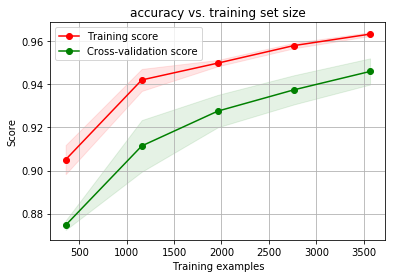

In [51]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", msg_train, label_train, cv=5)

(We're effectively training on 64% of all available data: we reserved 20% for the test set above, and the 5-fold cross validation reserves another 20% for validation sets => `0.8*0.8*5574=3567` training examples left.)

Since performance keeps **growing**, both for training and cross validation scores,
- we see our model is not complex/flexible enough to capture all nuance, given little data. 
- In this particular case, it's not very pronounced, since the accuracies are high anyway.



At this point, we have two options:

1. use more training data, to overcome low model complexity



2. use a more complex (lower bias) model to start with, to get more out of the existing data

Over the last years, as massive training data collections become more available, and as machines get faster, approach 1. is becoming more and more popular (simpler algorithms, more data). 

- Straightforward algorithms, such as Naive Bayes, also have the added benefit of being easier to interpret (compared to some more complex, black-box models, like neural networks).

Knowing how to evaluate models properly, we can now explore how different parameters affect the performace.

## Step 6: How to tune parameters?

What we've seen so far is only a tip of the iceberg: there are many other parameters to tune. One example is what algorithm to use for training.

We've used Naive Bayes above, but scikit-learn supports many classifiers out of the box: Support Vector Machines, Nearest Neighbours, Decision Trees, Ensamble methods...

[![](http://radimrehurek.com/data_science_python/drop_shadows_background.png)](http://peekaboo-vision.blogspot.cz/2013/01/machine-learning-cheat-sheet-for-scikit.html)

We can ask: What is the effect of IDF weighting on accuracy? Does the extra processing cost of lemmatization (vs. just plain words) really help?

Let's find out:

In [52]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_tokens),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # what type of cross validation to use
)

In [53]:
%time nb_detector = grid.fit(msg_train, label_train)
print nb_detector.grid_scores_

CPU times: user 3.46 s, sys: 163 ms, total: 3.63 s
Wall time: 12.9 s
[mean: 0.94595, std: 0.00607, params: {'tfidf__use_idf': True, 'bow__analyzer': <function split_into_lemmas at 0x10fd602a8>}, mean: 0.93137, std: 0.00803, params: {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_lemmas at 0x10fd602a8>}, mean: 0.94550, std: 0.00708, params: {'tfidf__use_idf': True, 'bow__analyzer': <function split_into_tokens at 0x1100ce5f0>}, mean: 0.92980, std: 0.00766, params: {'tfidf__use_idf': False, 'bow__analyzer': <function split_into_tokens at 0x1100ce5f0>}]


(best parameter combinations are displayed first: in this case, `use_idf=True` and `analyzer=split_into_lemmas` take the prize).

A quick sanity check:

In [54]:
print nb_detector.predict_proba(["Hi mom, how are you?"])[0]
print nb_detector.predict_proba(["WINNER! Credit for free!"])[0]

[ 0.99421159  0.00578841]
[ 0.36314474  0.63685526]


The `predict_proba` returns the predicted probability for each class (ham, spam). In the first case, the message is predicted to be ham with > 99% probability, and spam with < 1%. So if forced to choose, the model will say "ham":

In [55]:
print nb_detector.predict(["Hi mom, how are you?"])[0]
print nb_detector.predict(["WINNER! Credit for free!"])[0]

ham
spam


And overall scores on the test set, the one we haven't used at all during training:

In [56]:
predictions = nb_detector.predict(msg_test)
print confusion_matrix(label_test, predictions)
print classification_report(label_test, predictions)

[[933   0]
 [ 61 121]]
             precision    recall  f1-score   support

        ham       0.94      1.00      0.97       933
       spam       1.00      0.66      0.80       182

avg / total       0.95      0.95      0.94      1115



This is then the realistic predictive performance we can expect from our spam detection pipeline, when using lowercase with lemmatization, TF-IDF and Naive Bayes for classifier.

Let's try with another classifier: [Support Vector Machines (SVM)](http://en.wikipedia.org/wiki/Support_vector_machine). SVMs are a great starting point when classifying text data, getting state of the art results very quickly and with pleasantly little tuning (although a bit more than Naive Bayes):

In [57]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # what type of cross validation to use
)

In [58]:
%time svm_detector = grid_svm.fit(msg_train, label_train) # find the best combination from param_svm
print svm_detector.grid_scores_

CPU times: user 4.6 s, sys: 224 ms, total: 4.83 s
Wall time: 37.1 s
[mean: 0.98542, std: 0.00235, params: {'classifier__kernel': 'linear', 'classifier__C': 1}, mean: 0.98632, std: 0.00269, params: {'classifier__kernel': 'linear', 'classifier__C': 10}, mean: 0.98632, std: 0.00269, params: {'classifier__kernel': 'linear', 'classifier__C': 100}, mean: 0.98632, std: 0.00269, params: {'classifier__kernel': 'linear', 'classifier__C': 1000}, mean: 0.87329, std: 0.00006, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 1}, mean: 0.87329, std: 0.00006, params: {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'classifier__C': 1}, mean: 0.87329, std: 0.00006, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf', 'classifier__C': 10}, mean: 0.87329, std: 0.00006, params: {'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf', 'classifier__C': 10}, mean: 0.96950, std: 0.00527, params: {'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'

So apparently, linear kernel with `C=1` is the best parameter combination.

Sanity check again:

In [59]:
print svm_detector.predict(["Hi mom, how are you?"])[0]
print svm_detector.predict(["WINNER! Credit for free!"])[0]

ham
spam


In [60]:
print confusion_matrix(label_test, svm_detector.predict(msg_test))
print classification_report(label_test, svm_detector.predict(msg_test))

[[930   3]
 [ 15 167]]
             precision    recall  f1-score   support

        ham       0.98      1.00      0.99       933
       spam       0.98      0.92      0.95       182

avg / total       0.98      0.98      0.98      1115



This is then the realistic predictive performance we can expect from our spam detection pipeline, when using SVMs.

## Step 7: Productionalizing a predictor

With basic analysis and tuning done, the real work (engineering) begins.

- The final step for a production predictor would be training it on the entire dataset again, to make full use of all the data available. 
- We'd use the best parameters found via cross validation above, of course. 
    - This is very similar to what we did in the beginning, but this time having insight into its behaviour and stability. 
    - Evaluation was done honestly, on distinct train/test subset splits.

The final predictor can be serialized to disk, so that the next time we want to use it, we can skip all training and use the trained model directly:

In [61]:
# store the spam detector to disk after training
with open('sms_spam_detector.pkl', 'wb') as fout:
    cPickle.dump(svm_detector, fout)

# ...and load it back, whenever needed, possibly on a different machine
svm_detector_reloaded = cPickle.load(open('sms_spam_detector.pkl'))

The loaded result is an object that behaves identically to the original:

In [62]:
print 'before:', svm_detector.predict([message4])[0]
print 'after:', svm_detector_reloaded.predict([message4])[0]

before: ham
after: ham


Another important part of a production implementation is **performance**. 

- After a rapid, iterative model tuning and parameter search as shown here, a well performing model can be translated into a different language and optimized. 


- Would trading a few accuracy points give us a smaller, faster model? 


- Is it worth optimizing memory usage, perhaps using `mmap` to share memory across processes?

Note that optimization is not always necessary; always start with actual profiling.

Other things to consider here, for a production pipeline, are **robustness** (service failover, redundancy, load balancing), **monitoring** (incl. auto-alerts on anomalies) and **HR fungibility** (avoiding "knowledge silos" of how things are done, arcane/lock-in technologies, black art of tuning results). 


These days, even the open source world can offer viable solutions in all of these areas. All the tool shown today are free for commercial use, under OSI-approved open source licenses.